<a href="https://colab.research.google.com/github/San-B19/SanjanaB/blob/main/Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- WeatherWise App ---
Please enter the city and country (e.g., London, UK) for the weather forecast: Port Louis

--- Weather Data for Port Louis ---
📍 Current Weather: Light rain
📅 5-Day Forecast:
  2025-05-19 — 🌡️ 27.5°C to 28.9°C | ☔ 42% | Light rain
  2025-05-20 — 🌡️ 23.2°C to 23.2°C | ☔ 36% | Clear sky
  2025-05-21 — 🌡️ 23.5°C to 23.5°C | ☔ 7% | Few clouds
  2025-05-22 — 🌡️ 23.1°C to 23.1°C | ☔ 80% | Light rain
  2025-05-23 — 🌡️ 21.7°C to 21.7°C | ☔ 0% | Few clouds

Creating visualisations...


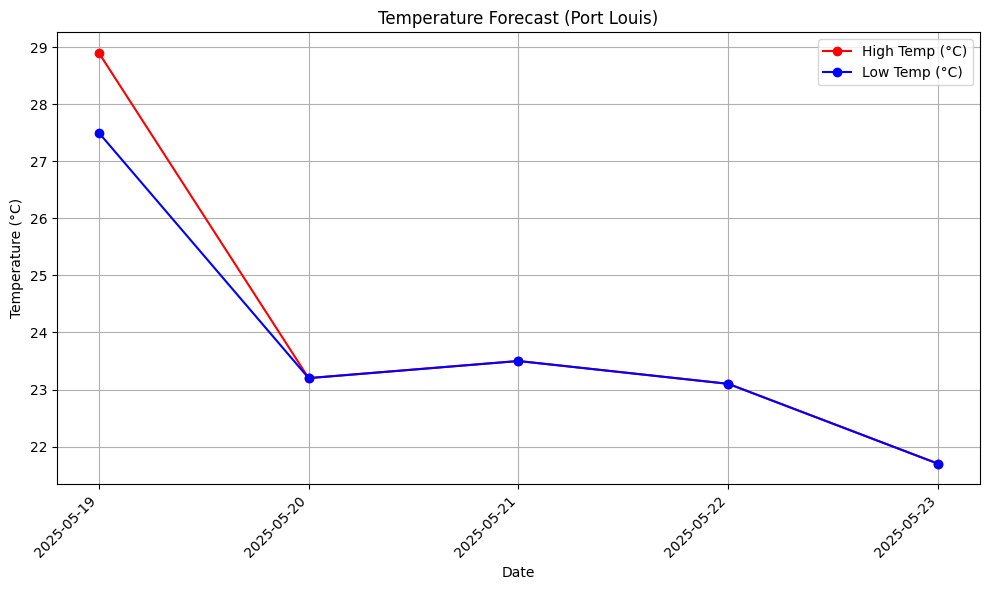

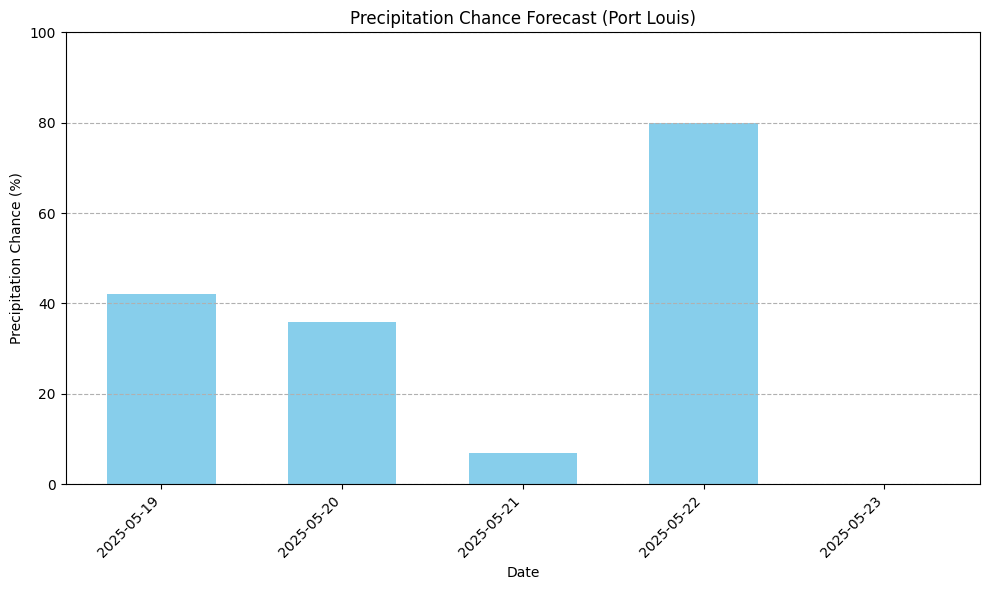


--- End of App ---


In [4]:
!pip install pyinputplus
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime
import matplotlib.dates
from IPython.display import display # Important for displaying plots in notebooks

# --- Setup and Configuration ---
# Get API key from environment, or prompt user if not set
api_key = os.environ.get("OPENWEATHER_API_KEY")
if not api_key:
    print("OpenWeatherMap API key not found in environment variables.")
    try:
        api_key = pyip.inputStr("Please enter your OpenWeatherMap API key: ")
        os.environ['OPENWEATHER_API_KEY'] = api_key # Set for this session
    except Exception as e:
        print(f"Failed to get API key input: {e}")
        api_key = None # Ensure api_key is None if input fails


# --- Weather Data Function ---

# Modified function to accept location as a parameter
def get_weather_data(location, forecast_days=5):
    """
    Retrieves current and forecast weather data for a specified location
    using OpenWeatherMap API.

    Parameters:
        location (str): The city and country (e.g., "London, UK") for which to get weather data.
        forecast_days (int): Number of forecast days to retrieve (maximum 5 for free tier).

    Returns:
        dict: {
            'current': {'summary': str},
            'forecast': [
                {
                    'date': str,
                    'high': float,
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    # Get API key from environment (set previously or via input)
    api_key = os.environ.get("OPENWEATHER_API_KEY")

    if not api_key:
        # Return a specific error if API key is not available at this point
        return {"error": "❌ Configuration error: OpenWeatherMap API key is not set."}

    try:
        # 📍 Use the provided location
        if not isinstance(location, str) or len(location.strip()) == 0:
             return {"error": "❌ Invalid location provided."}

        # 🌐 Prepare API request
        # Using the forecast endpoint which provides 5 days of 3-hour data
        # Use location from the function parameter
        url = (
            f"https://api.openweathermap.org/data/2.5/forecast"
            f"?q={location}&appid={api_key}&units=metric"
        )

        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data or not data.get("list"):
             # Check for common API errors like city not found
             if data and data.get("cod") == "404":
                 return {"error": f"❌ Location not found: {location}. Please check the city and country spelling."}
             else:
                 return {"error": "❌ API returned no data or invalid format."}


        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        for entry in data.get("list", []):
            dt_txt = entry.get("dt_txt")
            if not dt_txt:
                continue

            date = dt_txt.split(" ")[0]

            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0]

                forecast_entry = {
                    "date": date,
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    "precipChance": round(entry.get("pop", 0.0) * 100),
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            if len(forecast_data) >= forecast_days:
                break

        current_summary = data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize()
        current = {"summary": current_summary}

        return {
            "current": current,
            "forecast": forecast_data,
            "city_name": data.get("city", {}).get("name", location) # Include city name from API response
        }

    except requests.exceptions.RequestException as e:
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         return {"error": f"❌ Data processing error: {e}"}
    except KeyError as e:
        return {"error": f"❌ Data format error: Missing key {e}"}
    except Exception as e:
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Visualisation Functions (No changes needed here, they use the weather_data dict) ---

def create_temperature_visualisation(weather_data):
    """
    Creates and displays a temperature forecast visualisation (High and Low).
    Uses city name from weather_data if available.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create temperature visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]
    city_name = weather_data.get("city_name", "Location") # Get city name or use default

    dates = [day.get("date", "N/A") for day in forecast]
    highs = [day.get("high", 0.0) for day in forecast]
    lows = [day.get("low", 0.0) for day in forecast]

    plot_dates = []
    plot_highs = []
    plot_lows = []
    for i, d in enumerate(dates):
        if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_highs.append(highs[i])
                plot_lows.append(lows[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    plt.figure(figsize=(10, 6))

    plt.plot(plot_dates, plot_highs, marker='o', linestyle='-', color='red', label='High Temp (°C)')
    plt.plot(plot_dates, plot_lows, marker='o', linestyle='-', color='blue', label='Low Temp (°C)')

    # Update title to include city name
    plt.title(f"Temperature Forecast ({city_name})")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


def create_precipitation_visualisation(weather_data):
    """
    Creates and displays a precipitation chance forecast visualisation.
    Uses city name from weather_data if available.
    """
    if "error" in weather_data or not weather_data.get("forecast"):
        print("Cannot create precipitation visualisation: No valid forecast data.")
        return

    forecast = weather_data["forecast"]
    city_name = weather_data.get("city_name", "Location") # Get city name or use default

    dates = [day.get("date", "N/A") for day in forecast]
    precip_chances = [day.get("precipChance", 0) for day in forecast]

    plot_dates = []
    plot_precip_chances = []
    for i, d in enumerate(dates):
         if d != 'N/A':
            try:
                plot_dates.append(datetime.datetime.strptime(d, "%Y-%m-%d"))
                plot_precip_chances.append(precip_chances[i])
            except ValueError:
                print(f"Warning: Could not parse date '{d}'. Skipping entry for visualisation.")
                continue


    if not plot_dates:
        print("No valid dates found in forecast data for visualisation.")
        return

    plt.figure(figsize=(10, 6))

    plt.bar(plot_dates, plot_precip_chances, color='skyblue', width=0.6)

    # Update title to include city name
    plt.title(f"Precipitation Chance Forecast ({city_name})")
    plt.xlabel("Date")
    plt.ylabel("Precipitation Chance (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')

    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator())
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


# --- Main Application Logic (Example Usage with User Input) ---

print("--- WeatherWise App ---")

# Prompt the user for the location
user_location = pyip.inputStr("Please enter the city and country (e.g., London, UK) for the weather forecast: ")

# Call the function to get weather data for the user-specified location
weather_data = get_weather_data(user_location, forecast_days=5) # Pass the location and forecast days

# Display the results
if "error" in weather_data:
    print("\n--- Error ---")
    print(weather_data["error"])
else:
    # Use the city name from the API response for clarity
    city_name_display = weather_data.get("city_name", user_location)
    print(f"\n--- Weather Data for {city_name_display} ---")
    print("📍 Current Weather:", weather_data.get("current", {}).get("summary", "N/A"))
    forecast_length = len(weather_data.get('forecast', []))
    print(f"📅 {forecast_length}-Day Forecast:")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

    # Create and display visualisations if data is available
    print("\nCreating visualisations...")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

print("\n--- End of App ---")